In [41]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
import os

In [50]:
d = "C:\kaggle_data\credit_card"
lst = os.listdir(d)
print(lst)
train = pd.read_csv(d + '\\' +lst[3])
test = pd.read_csv(d + '\\' +lst[2])
ss = pd.read_csv(d + '\\' +lst[1])
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

['.ipynb_checkpoints', 'sample_submission.csv', 'test.csv', 'train.csv', 'Untitled.ipynb']


# 전처리

In [51]:
# income_total을 로그변환 한 새로운 feature log_income
# 기존 칼럼 삭제
train['log_income'] = np.log(train['income_total'])
train = train.drop('income_total',1)
test['log_income'] = np.log(test['income_total'])
test = test.drop('income_total',1)

In [52]:
# car와 reality를 합친 새로운 칼럼 careality
train['careality'] = train['car'] + train['reality']
train = train.drop(['car', 'reality'],1)

test['careality'] = test['car'] + test['reality']
test = test.drop(['car', 'reality'],1)

In [53]:
def tf(x):
    if x < 0:
        return np.log(abs(x))
    else:
        return -(np.log(15173) * (365243/15173))

In [54]:
# outlier 제외 최대값 == 15713
# 비율 15173 / 365243 
# 
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(tf)

In [55]:
# np.log(15173) == 9.627272811525241
# (15173/365243) == 0.04~~~
-(np.log(15173) * (365243/15173))

-231.74678728662187

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Density'>

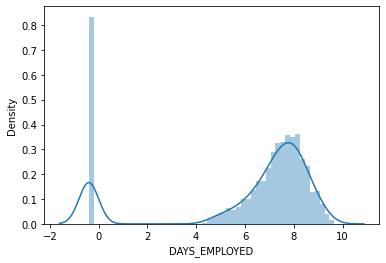

In [47]:
# 
sns.distplot(train['DAYS_EMPLOYED'])

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Density'>

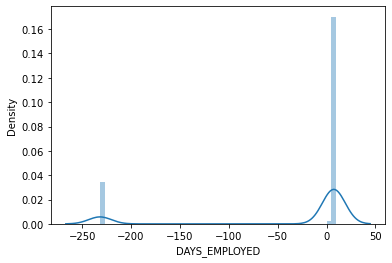

In [56]:
sns.distplot(train['DAYS_EMPLOYED'])

In [57]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

In [58]:
enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [59]:
test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

# 모델링, 학습

In [60]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [61]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650091	valid_1's multi_logloss: 0.74999
[200]	training's multi_logloss: 0.563702	valid_1's multi_logloss: 0.7352
[300]	training's multi_logloss: 0.499608	valid_1's multi_logloss: 0.729651
Early stopping, best iteration is:
[335]	training's multi_logloss: 0.480671	valid_1's multi_logloss: 0.727603


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.64656	valid_1's multi_logloss: 0.762207
[200]	training's multi_logloss: 0.560065	valid_1's multi_logloss: 0.747825
[300]	training's multi_logloss: 0.49572	valid_1's multi_logloss: 0.744242
Early stopping, best iteration is:
[353]	training's multi_logloss: 0.467242	valid_1's multi_logloss: 0.74308


====================================3=========

In [62]:
ss.iloc[:,1:]=0
for fold in range(5):
    ss.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [63]:
ss.to_csv('baseline_days_employed.csv', index=False)

In [64]:
# log_income을 사용했을 때의 점수
from sklearn.model_selection import cross_val_score

print(cross_val_score(lgb_models[0], train.drop(['credit'],axis=1), train['credit'], cv=skf).mean())

0.7057109414252272
